# Hierarchical bootstrap

## Set-up

### Imports

In [1]:
# auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [3]:
import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from paired_hierarchical_bootstrap import hierarchical_bootstrap as run_hb


### Settings

In [4]:
N_ITERATIONS = 1000 # number of iterations for bootstrapping
VAR = 'exponent' # variable to analyze

### functions

## Main

### load specparam results

In [5]:
# load spectral parameterization results
results = pd.read_csv(f"{PROJECT_PATH}/data/results/spectral_parameters.csv", index_col=0)
results.drop(columns='index', inplace=True)

# show
print(results.shape)
print(len(results)/8)
results.head()

(5560, 26)
695.0


,patient,chan_idx,label,pos_y,pos_x,pos_z,material,memory,epoch,offset,...,gamma_pw,gamma_bw,error,r_squared,r2_adj,f_rotation,alpha,alpha_adj,gamma,gamma_adj
0,pat02,0,A01-A02,-65.43100,61.94490,3.55955,words,hit,pre,8.286192,...,NaN,NaN,0.069006,0.992773,0.992538,46.908382,4.439106,0.111771,1.947740,0.014498
1,pat02,1,A02-A03,-70.93895,57.17765,12.15540,words,hit,pre,7.635405,...,NaN,NaN,0.062446,0.991529,0.991252,29.941520,4.148422,0.052966,1.980923,0.064095
2,pat02,2,A03-A04,-75.39550,51.39440,20.94335,words,hit,pre,7.266282,...,NaN,NaN,0.054597,0.992668,0.992428,19.961014,4.169199,0.157993,1.984640,0.017393
3,pat02,3,A04-A05,-78.91950,43.90980,30.13485,words,hit,pre,7.491955,...,0.249224,2.712309,0.056073,0.992178,0.991923,49.902534,4.362397,0.056976,2.267206,0.039581
4,pat02,4,A05-A06,-80.96735,35.21485,38.13475,words,hit,pre,7.505439,...,NaN,NaN,0.069188,0.989511,0.989169,59.883041,4.332351,0.070960,2.185415,0.027424


In [6]:
# get results for task-modulated channels only

# load task-modulated channel info
task_modulated_channels = pd.read_csv(f"{PROJECT_PATH}/data/results/ieeg_modulated_channels.csv", index_col=0)

# join info with results
df_merge = pd.merge(results, task_modulated_channels, on=['patient','chan_idx'])

# get task-modulated channel results only
results = df_merge.loc[df_merge['sig_all']].reset_index(drop=True)
results

,patient,chan_idx,label,pos_y,pos_x,pos_z,material,memory,epoch,offset,...,r2_adj,f_rotation,alpha,alpha_adj,gamma,gamma_adj,sig_alpha,sig_gamma,sig_all,sig_any
0,pat04,0,A01-A09,-58.3012,52.43075,-26.23685,words,hit,pre,8.239496,...,0.989531,38.923977,5.070158,0.385050,2.657652,0.009833,True,True,True,True
1,pat04,0,A01-A09,-58.3012,52.43075,-26.23685,words,hit,post,7.220917,...,0.979107,38.923977,4.689450,0.248050,2.818429,0.012936,True,True,True,True
2,pat04,0,A01-A09,-58.3012,52.43075,-26.23685,words,miss,pre,8.052575,...,0.982049,32.935673,5.037571,0.295203,2.652605,0.008835,True,True,True,True
3,pat04,0,A01-A09,-58.3012,52.43075,-26.23685,words,miss,post,7.352709,...,0.980493,32.935673,4.798010,0.292164,2.825678,0.020334,True,True,True,True
4,pat04,0,A01-A09,-58.3012,52.43075,-26.23685,faces,hit,pre,7.847930,...,0.987033,21.957115,4.985783,0.316548,2.648061,0.013728,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,pat22,44,LOF_08-LOF_09,47.0000,-25.00000,24.00000,words,miss,post,7.315293,...,0.969077,13.972710,3.075311,-0.020160,1.534857,0.033797,True,True,True,True
484,pat22,44,LOF_08-LOF_09,47.0000,-25.00000,24.00000,faces,hit,pre,7.036297,...,0.983358,43.914230,3.115896,-0.044448,1.487642,0.018719,True,True,True,True
485,pat22,44,LOF_08-LOF_09,47.0000,-25.00000,24.00000,faces,hit,post,7.096550,...,0.970144,43.914230,2.940412,-0.028118,1.601672,0.123164,True,True,True,True
486,pat22,44,LOF_08-LOF_09,47.0000,-25.00000,24.00000,faces,miss,pre,7.134941,...,0.973864,27.945419,3.041570,-0.070410,1.526409,0.042513,True,True,True,True


In [7]:
# split results by trial type (words/faces) and take successful trials only (memory==hit)
df_w = results.loc[((results['memory']=='hit')&(results['material']=='words'))]
df_f = results.loc[((results['memory']=='hit')&(results['material']=='faces'))]
df_w

,patient,chan_idx,label,pos_y,pos_x,pos_z,material,memory,epoch,offset,...,r2_adj,f_rotation,alpha,alpha_adj,gamma,gamma_adj,sig_alpha,sig_gamma,sig_all,sig_any
0,pat04,0,A01-A09,-58.30120,52.43075,-26.23685,words,hit,pre,8.239496,...,0.989531,38.923977,5.070158,0.385050,2.657652,0.009833,True,True,True,True
1,pat04,0,A01-A09,-58.30120,52.43075,-26.23685,words,hit,post,7.220917,...,0.979107,38.923977,4.689450,0.248050,2.818429,0.012936,True,True,True,True
8,pat04,5,A10-A18,-48.67445,61.57940,-21.63940,words,hit,pre,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
9,pat04,5,A10-A18,-48.67445,61.57940,-21.63940,words,hit,post,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
16,pat04,6,A11-A19,-45.27960,64.12270,-9.09570,words,hit,pre,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,pat22,11,IFG_07-IFG_08,25.00000,-58.00000,4.50000,words,hit,post,5.771666,...,0.973397,52.896686,2.504071,-0.066238,0.160350,-0.073504,True,True,True,True
472,pat22,24,PI_04-PI_05,-10.00000,-40.00000,25.50000,words,hit,pre,9.222787,...,0.964056,55.890838,3.129613,-0.041646,1.596671,0.017286,True,True,True,True
473,pat22,24,PI_04-PI_05,-10.00000,-40.00000,25.50000,words,hit,post,7.772763,...,0.961864,55.890838,3.501059,-0.062849,1.688897,0.041661,True,True,True,True
480,pat22,44,LOF_08-LOF_09,47.00000,-25.00000,24.00000,words,hit,pre,7.540632,...,0.982647,32.935673,3.048000,-0.087247,1.457544,0.022584,True,True,True,True


### Permutation statistics
Here we shuffle the labels for the condition of interest (baseline v. encoding), ignoring the hierarchical structure of the data.

In [26]:
def run_permutation_test(df, variable, condition, n_iterations=1000, verbose=True, plot=True):

    # get distribution of surrogate differences between groups
    distribution = np.zeros(n_iterations)
    for i_iter in range(n_iterations):
        # resample condition
        df_copy = df.copy()
        df_copy[f"{condition}_resampled"] = np.random.permutation(df[condition].values)

        # compute difference between surrogate groups
        distribution[i_iter] = np.diff(df_copy.groupby(f"{condition}_resampled").mean()[variable].values)

    # compute true difference
    diff = np.diff(df.groupby(condition).mean()[variable].values)[0]

    # compute p-value
    p_value = min(np.sum(distribution > diff), np.sum(distribution < diff)) / len(distribution)

    # print results
    if verbose:
        print(f"true difference: {diff}")
        print(f"p-value: {p_value}")

    # plot results
    if plot:
        _, ax = plt.subplots(figsize=(6,4))
        ax.hist(distribution, bins=20, color='k', alpha=0.5, label='surrogate difference')
        ax.axvline(diff, color='r', label='true difference')
        ax.set_xlabel(f'difference')
        ax.set_ylabel('count')
        ax.set_title('Permutation results')
        ax.legend()
        plt.show()

    return p_value, diff, distribution

================= Word-encoding =================
true difference: 0.011281243250917061
p-value: 0.368


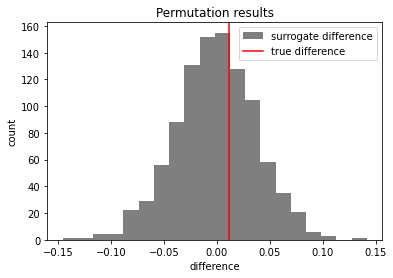

================= Face-encoding =================
true difference: 0.014965382115122772
p-value: 0.317


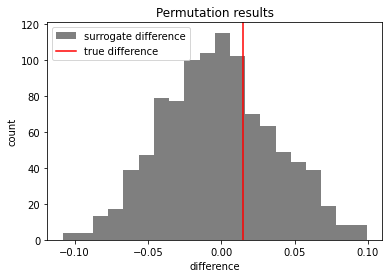

In [27]:
# run permutation test - total alpha power

print("================= Word-encoding =================")
p_value, diff, distribution = run_permutation_test(df_w, variable='alpha', condition='epoch', n_iterations=1000)

print("================= Face-encoding =================")
p_value, diff, distribution = run_permutation_test(df_f, variable='alpha', condition='epoch', n_iterations=1000)


================= Word-encoding =================
true difference: 0.07954693153732562
p-value: 0.002


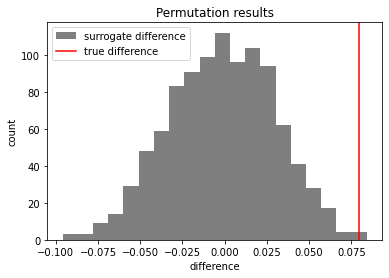

================= Face-encoding =================
true difference: 0.06948894542017037
p-value: 0.008


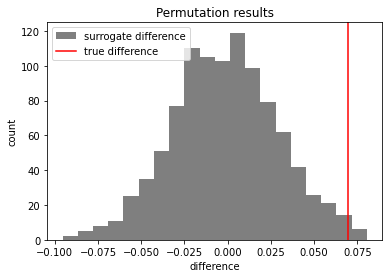

In [28]:
# run permutation test - exponent

print("================= Word-encoding =================")
p_value, diff, distribution = run_permutation_test(df_w, variable='exponent', condition='epoch', n_iterations=1000)

print("================= Face-encoding =================")
p_value, diff, distribution = run_permutation_test(df_f, variable='exponent', condition='epoch', n_iterations=1000)


================= Word-encoding =================
true difference: -0.004606553580488892
p-value: 0.431


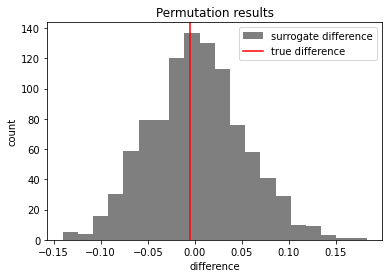

================= Face-encoding =================
true difference: 0.05384290222275956
p-value: 0.127


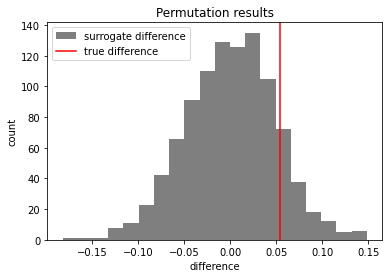

In [29]:
# run permutation test - adjusted alpha power

print("================= Word-encoding =================")
p_value, diff, distribution = run_permutation_test(df_w, variable='alpha_adj', condition='epoch', n_iterations=1000)

print("================= Face-encoding =================")
p_value, diff, distribution = run_permutation_test(df_f, variable='alpha_adj', condition='epoch', n_iterations=1000)


### perform hierarchical bootstrap
level 1: epoch (experimental condition)  
level 2: patient  
level 3: channel

#############################################
word-encoding
#############################################

Variable: exponent
p-value: <0.01
True mean difference: -0.25
Condition 'pre' > 'post'

Variable: alpha
p-value: <0.01
True mean difference: -0.18
Condition 'pre' > 'post'

Variable: alpha_adj
p-value: 0.100
True mean difference: -0.06
Condition 'pre' > 'post'

Variable: gamma
p-value: 0.010
True mean difference: 0.09
Condition 'post' > 'pre'

Variable: gamma_adj
p-value: 0.140
True mean difference: 0.01
Condition 'post' > 'pre'
#############################################
face-encoding
#############################################

Variable: exponent
p-value: <0.01
True mean difference: -0.44
Condition 'pre' > 'post'

Variable: alpha
p-value: <0.01
True mean difference: -0.20
Condition 'pre' > 'post'

Variable: alpha_adj
p-value: <0.01
True mean difference: -0.10
Condition 'pre' > 'post'

Variable: gamma
p-value: <0.01
True mean difference: 0.16
Condition 'post' > 'pre'

Variabl

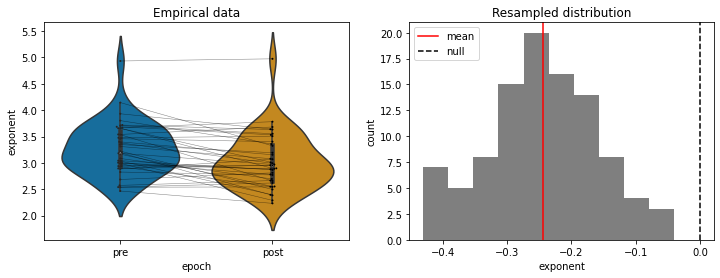

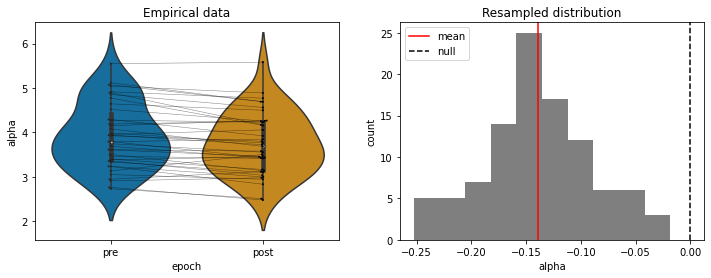

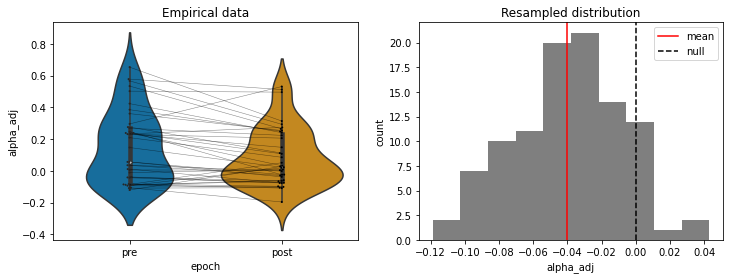

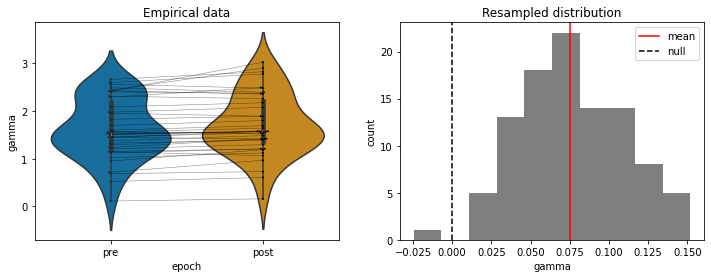

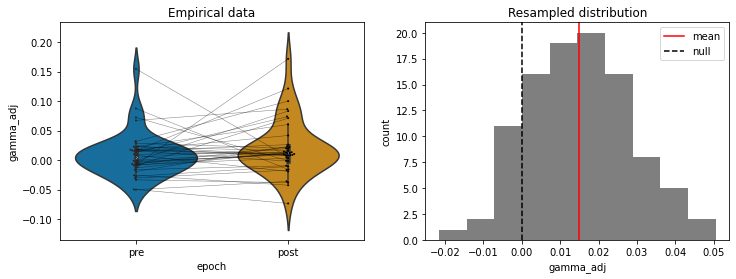

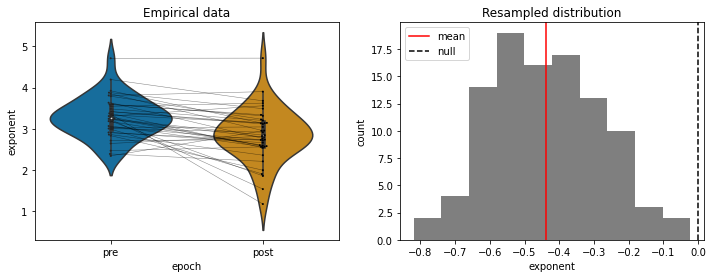

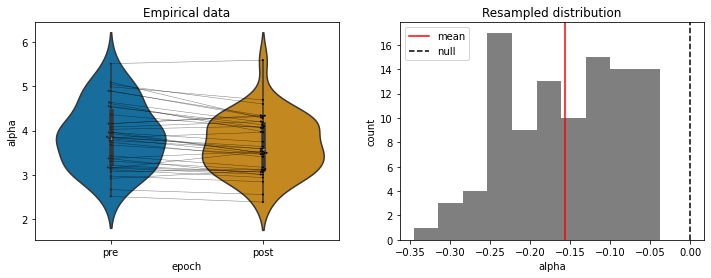

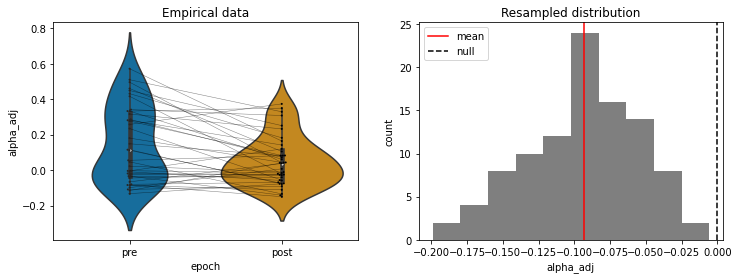

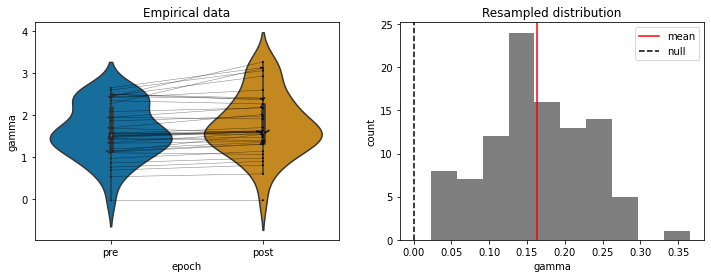

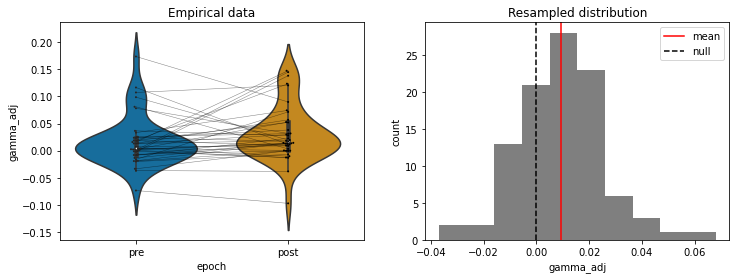

In [18]:
# apply hierarchical bootstrap for each trial type and variable oF interest
features = ['exponent', 'alpha', 'alpha_adj', 'gamma', 'gamma_adj']

for df, material in zip([df_w, df_f],['word-encoding','face-encoding']):
    # display progress
    print("#############################################")
    print(material)
    print("#############################################")

    for feature in features:
        # display progress
        print(f"\nVariable: {feature}")

        # drop nan values
        df_r = df.copy()
        df_r = df_r.dropna(subset=feature)

        # apply hierarchical bootstrap
        run_hb(df_r, feature, 'epoch', 'patient', 'chan_idx', 100)

### Subsequent memory effect

In [20]:
# split results by trial type (words/faces)
df_w = results.loc[results['material']=='words']
df_f = results.loc[results['material']=='faces']

#############################################
word-encoding
#############################################

Variable: exponent
p-value: 0.470
True mean difference: -0.04
Condition 'hit' > 'miss'

Variable: alpha
p-value: 0.480
True mean difference: -0.00
Condition 'hit' > 'miss'

Variable: alpha_adj
p-value: 0.310
True mean difference: 0.03
Condition 'miss' > 'hit'

Variable: gamma
p-value: 0.240
True mean difference: 0.00
Condition 'miss' > 'hit'

Variable: gamma_adj
p-value: 0.350
True mean difference: -0.00
Condition 'hit' > 'miss'
#############################################
face-encoding
#############################################

Variable: exponent
p-value: 0.020
True mean difference: 0.04
Condition 'miss' > 'hit'

Variable: alpha
p-value: 0.270
True mean difference: 0.01
Condition 'miss' > 'hit'

Variable: alpha_adj
p-value: 0.200
True mean difference: 0.02
Condition 'miss' > 'hit'

Variable: gamma
p-value: 0.090
True mean difference: -0.01
Condition 'hit' > 'miss'

Variable:

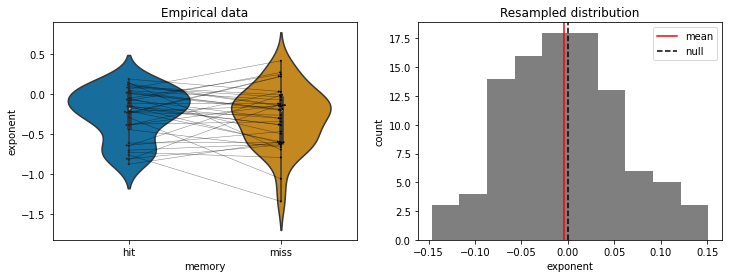

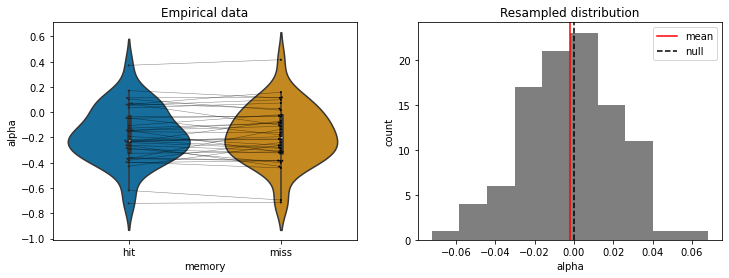

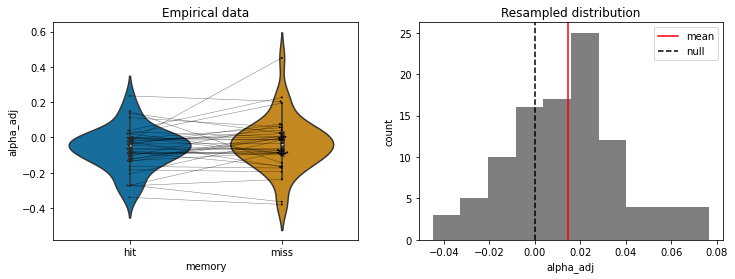

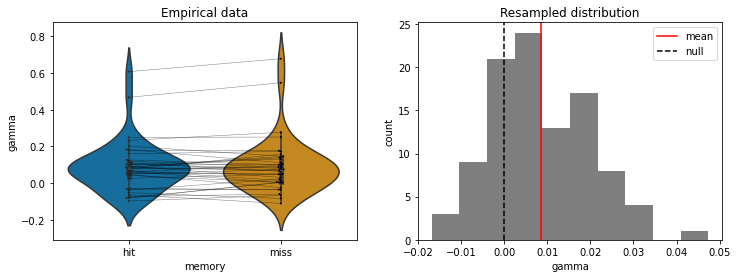

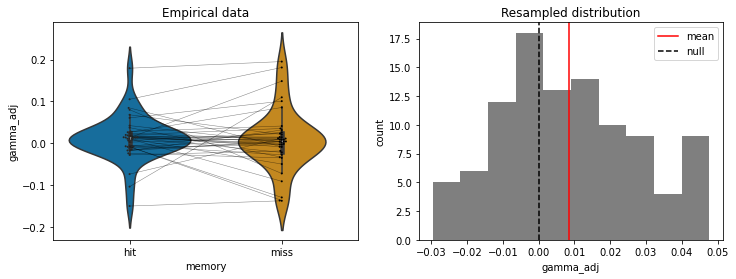

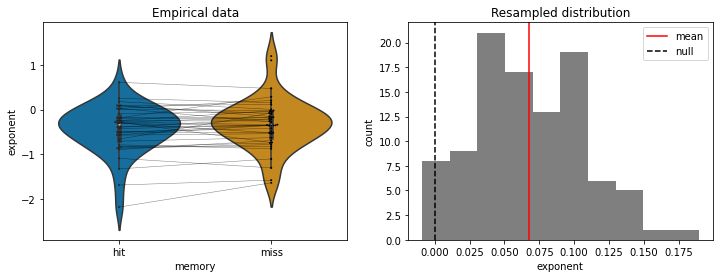

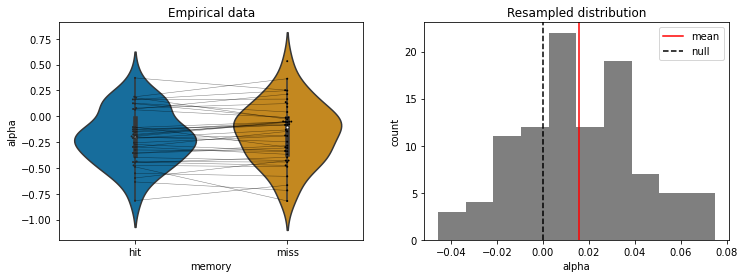

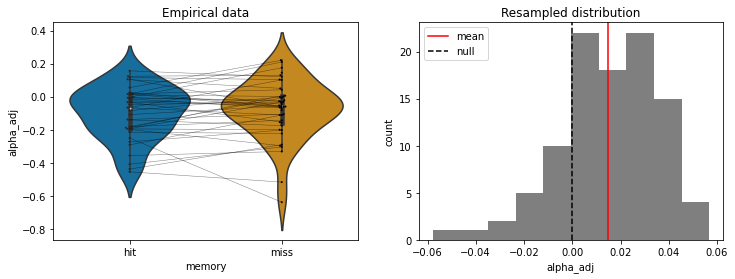

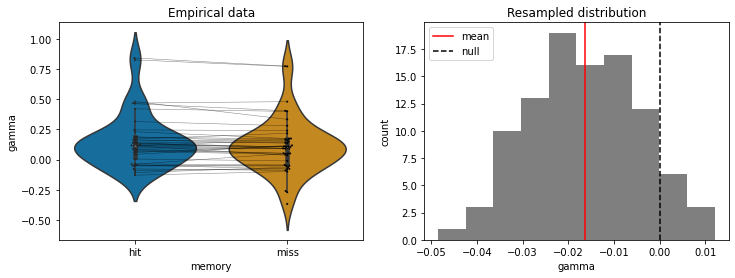

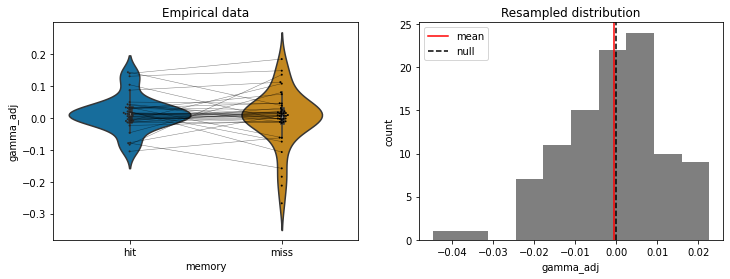

In [21]:
# apply hierarchical bootstrap for each trial type and variable oF interest
features = ['exponent', 'alpha', 'alpha_adj', 'gamma', 'gamma_adj']

for df, material in zip([df_w, df_f],['word-encoding','face-encoding']):
    # display progress
    print("#############################################")
    print(material)
    print("#############################################")

    for feature in features:
        # display progress
        print(f"\nVariable: {feature}")

        # compute difference between pre and post
        df_p = df.pivot_table(index=['patient','chan_idx','memory'], 
                                columns='epoch', values=feature).reset_index()
        df_p[feature] = df_p['post'] - df_p['pre']

        # drop nan values
        df_p = df_p.dropna()

        # apply hierarchical bootstrap
        run_hb(df_p, feature, 'memory', 'patient', 'chan_idx', 100)